## Building an image classifier using opencv 

In this notebook, I experiment with ways to create a classifier for 30 cell images that rae in 3 different classes. There is not enough data to do any meaningful machine learning, but we can try to develop a heuristic method. 

This notebook investigates several approaches: 

1. Edge Detection 
2. Shape extraction: generation of contours
3. Shape Detection and Comparison 
4. 2-D clustering methods 


### Reading List

Transformations:  
http://answers.opencv.org/question/131161/transform-16bit-grayscale-to-rgb-with-constants/  
https://stackoverflow.com/questions/18446804/python-read-and-write-tiff-16-bit-three-channel-colour-images  

normalization:  
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html  
https://www.programcreek.com/python/example/89458/cv2.adaptiveThreshold  
https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=adaptivethreshold  

color conversions Cpp:  
https://stackoverflow.com/questions/50674072/change-16-bit-grayscale-image-to-color-image-using-opencv-and-c 

Canny Edge Detection:
https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html

Contours:
https://docs.opencv.org/3.4.2/d4/d73/tutorial_py_contours_begin.html

watershed:  
http://www.cmm.mines-paristech.fr/~beucher/wtshed.html#watshed  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html  

hack to make ohtsu work:  
https://stackoverflow.com/questions/48382621/opencv-watershed-otsu-with-distancetransform  
https://www.quora.com/How-do-I-convert-a-grayscale-image-to-an-RGB-image-in-Python  

In [706]:
import sys, os, glob
import cv2
import sklearn, math
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import tifffile as tiff
from scipy.misc import bytescale
import PIL
import pandas as pd

home_dir = os.path.abspath('./');print(home_dir)
ud = '/tdata1/luminex_challenge/'


/home/ubuntu/git/luminex_dsuciu


## 0. Helper Functions

In [1387]:
def import_bytescale(img_p):
    img16 = np.int16(cv2.imread(img_p, -1))
    img8 = bytescale(img16)
    return img8

def importImage16b(img_p):
    img = cv2.imread(img_p, -1)
    return img

def import_images(plst, import_funct=import_bytescale):
    oLst = []
    for imgp in plst:
        oLst.append(import_funct(imgp))
        image_stats(oLst[-1], end='\r')
    return oLst

def tiff_to_rgb(img_path, img=None, scale=1000.0):
    if img is None:
        img = tiff.imread(img_path)
    r,c = img.shape
    out_arr = np.ones((r,c,3), dtype=np.float)
    for i in range(r):
        for j in range(c):
            v = min(img[i][j]/scale, 1.0)*255
            out_arr[i][j] = np.ones(3)*v
    print(out_arr.max())
    return out_arr.astype(np.uint8)

def image_stats(img, end='\n'):
    x = img.flatten()
    px = 0
    if len(img.shape)==3:
        h,w,px = img.shape
    else:
        h,w = img.shape
    print ("type: %s dtype: %s sz: %s, max_val: %i pixels>0: %i of %i"%(str(type(img)), img.dtype, str(img.shape), x.max(), len(x[x>0]), h*w), end=end)

def image_histo(img):
    if len(img.shape)==2:
        image_stats(img)
        x = img.flatten()
        c,vv,pp = plt.hist(x[x>0], 50, density=False, facecolor='g', alpha=0.75)
    else:
        color = ('b','g','r')
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
            plt.ylabel('log pixel color counts')
            plt.yscale('log')
            
def colorize(img_gray, colormap=cv2.COLORMAP_JET):
    #https://www.learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
    """0	COLORMAP_AUTUMN	colorscale_autumn
        1	COLORMAP_BONE	colorscale_bone
        2	COLORMAP_JET	colorscale_jet
        3	COLORMAP_WINTER	colorscale_winter
        4	COLORMAP_RAINBOW	colorscale_rainbow
        5	COLORMAP_OCEAN	colorscale_ocean
        6	COLORMAP_SUMMER	colorscale_summer
        7	COLORMAP_SPRING	colorscale_spring
        8	COLORMAP_COOL	colorscale_cool
        9	COLORMAP_HSV	colorscale_hsv
        10	COLORMAP_PINK	colorscale_pink
        11	COLORMAP_HOT	colorscale_hot"""
    return cv2.applyColorMap(img_gray, colormap)

def image_show_histo(img, figsize=(10,5)):
    image_stats(img)
    x = img.flatten()
    plt.figure(figsize=figsize)
    columns=2
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(colorize(img))
    plt.subplot(1, 3, 3)
    image_histo(img)#plt.hist(x[x>0], 25, density=False, cumulative=False, facecolor='g', alpha=0.75)
        

def plotImages(lst, columns=10, figsize=(20,10), PlotHisto=False):
    plt.figure(figsize=figsize)
    n = len(lst)
    for i, image in enumerate(lst):
        plt.subplot(n / columns + 1, columns, i + 1)
        if PlotHisto:
            x = image.flatten()
            c,vv,pp = plt.hist(x[x>0], PlotHisto, density=False, facecolor='g', alpha=0.75)
        else: plt.imshow(image)
        
def multiplot(lst, columns=10, figsize=(20,10)):
    plt.figure(figsize=figsize)
    n = len(lst)
    for i, plot in enumerate(lst):
        plt.subplot(n / columns + 1, columns, i + 1)
        plt.show(plot)
        
def PlotSimilarityMatrix(sm, figsize=(15,15), no_plot=False, title='similarity'):
    n=len(sm)
    n_y, n_x = sm.shape
    x = range(n_x)
    y = range(n_y)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(sm)
    # We want to show all ticks...
    ax.set_xticks(np.arange(n_x))
    ax.set_yticks(np.arange(n_y))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(n_x):
        for j in range(n_y):
            text = ax.text(i, j, "%0.2f"%sm[j][i],
                           ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    if no_plot:return
    plt.show()




#### Three ways of importing the images. Most openCV is written to use uint8 arrays, our data is uint16 grayscale. So we explored several ways of importing and converting the data. 

In [1356]:
#glob Filenames:
fileLst = glob.glob(ud + "class*/*tif")
fileLst.sort()
imgLst_u8 = import_images(fileLst, import_funct=import_bytescale)
imgLst_u16 = import_images(fileLst, import_funct=importImage16b)
imgLst_8uc1 = import_images(fileLst, import_funct=lambda x: cv2.imread(x, cv2.CV_8UC1));

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  This is separate from the ipykernel package so we can avoid doing imports until


type: <class 'numpy.ndarray'> dtype: uint8 sz: (45, 38), max_val: 255 pixels>0: 1150 of 1710
type: <class 'numpy.ndarray'> dtype: uint8 sz: (45, 38), max_val: 255 pixels>0: 1150 of 1710


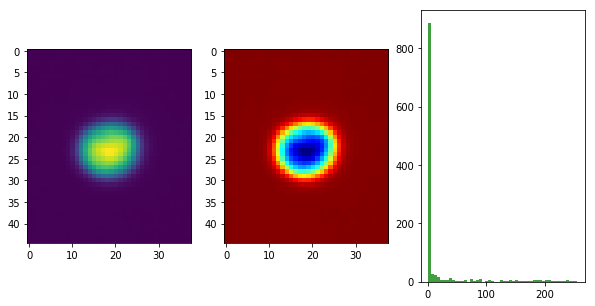

In [1043]:
img = imgLst_u8[0]

image_show_histo(img, figsize=(10,5))

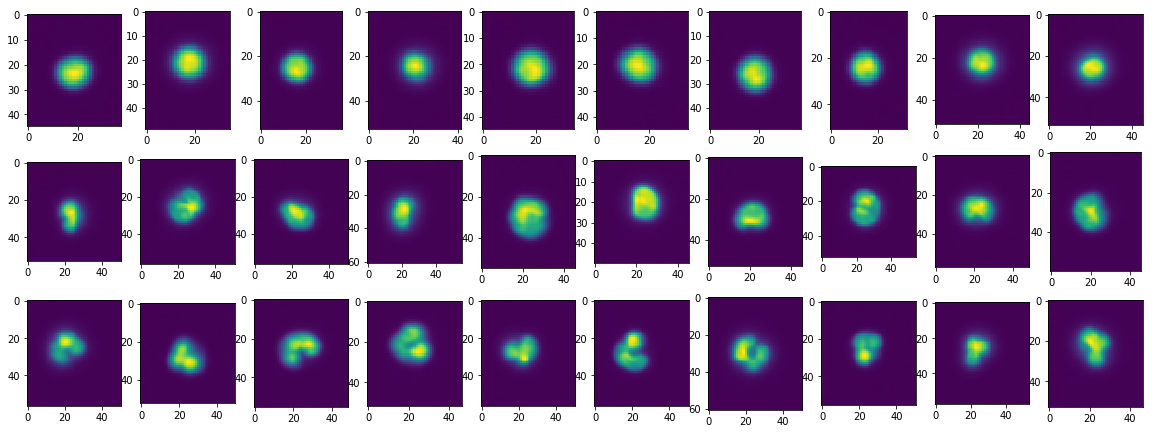

In [182]:
#Load ImageLst:

plotImages(imgLst_u8)

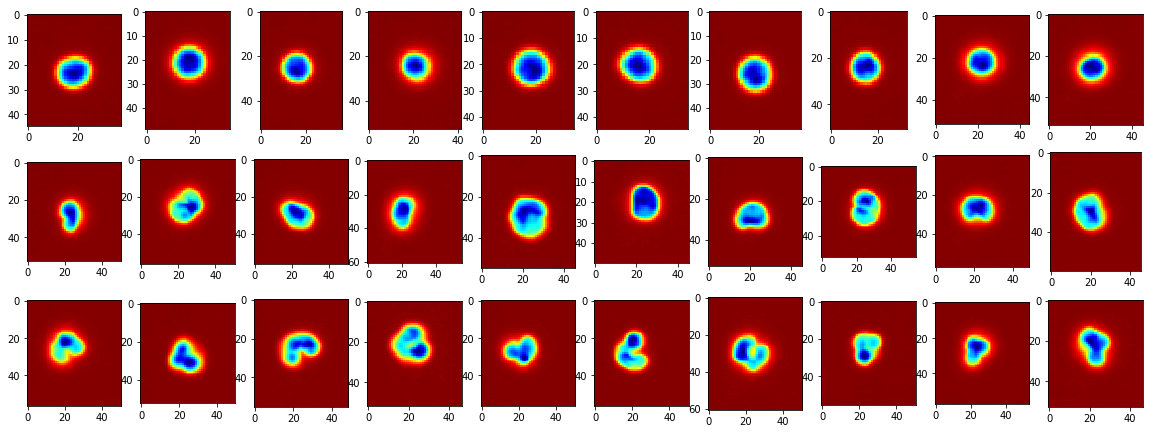

In [479]:
plotImages([colorize(img_gray) for img_gray in imgLst_u8])

## 1. Using Canny Edge Detector to look for shapes at various thresholds: 

In this section, I tried to see if there was a way to differentiate the three shape types using the intensity landscape, which is clearly visible in the colorized images above. This intensity landscape reveals that there are 1, 2 and 3 distinct structures in classes A,B, and C, respectively. 
It was hoped that by varying the lower and upper Canny thresholds, that we could see multiple shapes at different thresholding levels. 


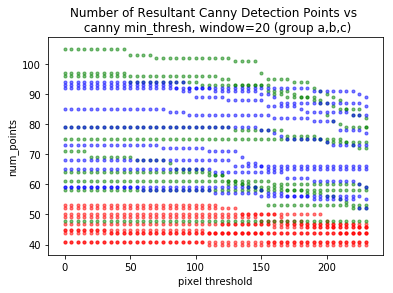

In [717]:
#https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html

def canny_test(img):
    vlst = [];olst=[]
    for i in range(0,235,5):
        edges = cv2.Canny(img,i,i+20,apertureSize = 3)
        x = edges.flatten()
        vlst.append([i, len(x[x>0])])
        olst.append(edges)
    return vlst, olst
colors = ("red", "green", "blue")
plotLst = []
idx = 0
for img in imgLst_u8[:]:
    l, ilst = canny_test(img)
    area = np.pi*3
    x = [v[0] for v in l]
    y = [v[1] for v in l]
    plt.scatter(x, y, s=area, c=colors[int(idx/10)], alpha=0.5)
    plt.title('Number of Resultant Canny Detection Points vs \n canny min_thresh, window=20 (group a,b,c)')
    plt.xlabel('pixel threshold')
    plt.ylabel('num_points')
    plotLst.append(plt)
    idx+=1
    
plt.show()

#### The three rows below are class A, B and C, respectively.

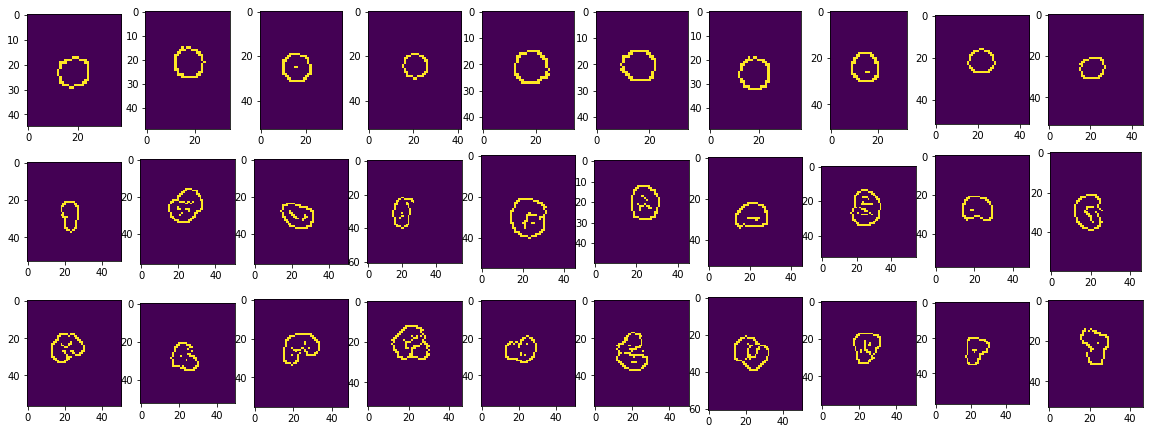

In [1278]:
clst = []
step=10
for i in range(0,30,1):
    clst.append(cv2.Canny(imgLst_u8[i], 50,255,apertureSize = 5))
plotImages(clst, columns = 10)

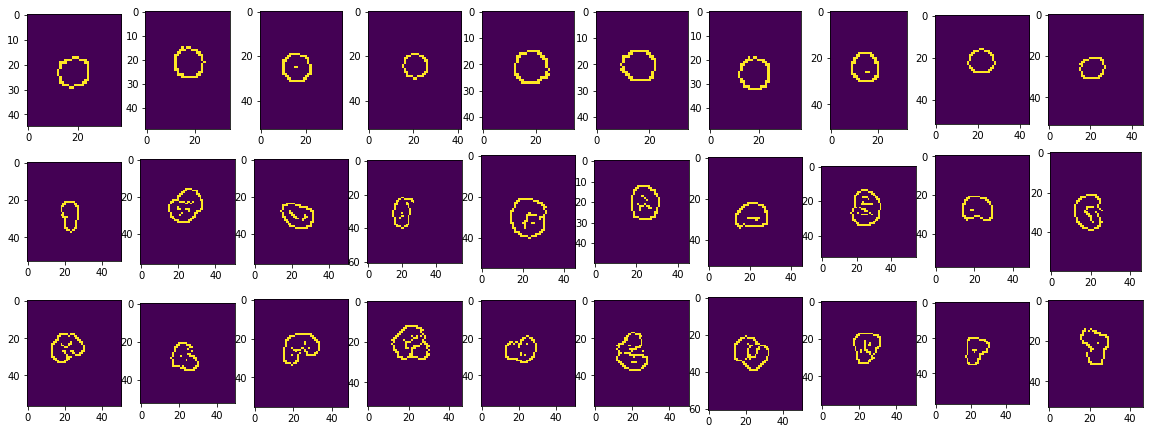

In [1276]:
clst = []
step=10
for i in range(0,30,1):
    clst.append(cv2.Canny(imgLst_u8[i],255,255,apertureSize = 5))
plotImages(clst, columns = 10)

#### Its very hard to get conditions to see differences between the different classes. 

## 2. Compute Contours:  

In this method, we use Canny Edges, pull an exterior contour mask and use that to do a simple shape comparison using Humoments.

contours: 2
0 cnt_sz: 1
1 cnt_sz: 62


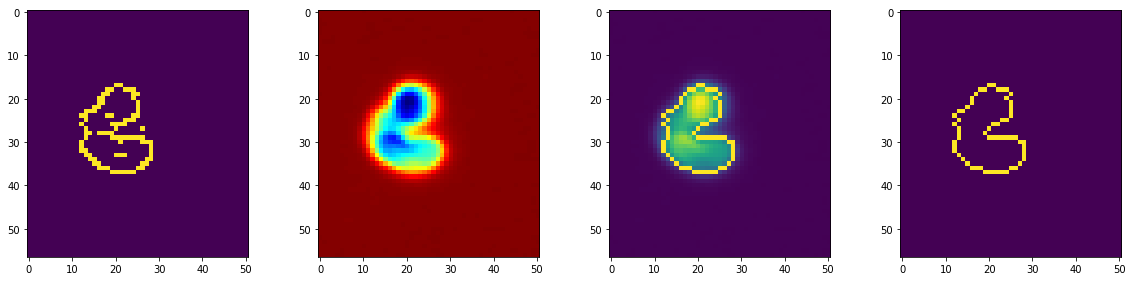

In [695]:
idx = 25
in_img=clst[idx].copy()#  imgLst_u8[1].copy()
ret, thresh = cv2.threshold(in_img, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print('contours:', len(contours))
dlst = [in_img, colorize(imgLst_u8[idx])]
for i in range(len(contours)):
    cnt_sz = len(contours[i])
    print(i, 'cnt_sz:', cnt_sz)
    if cnt_sz<10:continue
    ximg = cv2.drawContours(imgLst_u8[idx].copy(), contours, i, (255,255,255), 1)
    dlst.append(ximg)
    o_img = np.zeros(in_img.shape, dtype=np.uint8)
    ximg = cv2.drawContours(o_img, contours, 1, (255,255,255), 1)
    dlst.append(ximg)
plotImages(dlst, columns=4, figsize=(20,10))

In [1279]:
def compute_contour_mask(in_img):
    im2, contours, hierarchy = cv2.findContours(in_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    o_img = np.zeros(in_img.shape, dtype=np.uint8)
    
    ximg = cv2.drawContours(o_img, contours, np.argmax([len(cnt) for cnt in contours]), (255,255,255), 1)
    return ximg

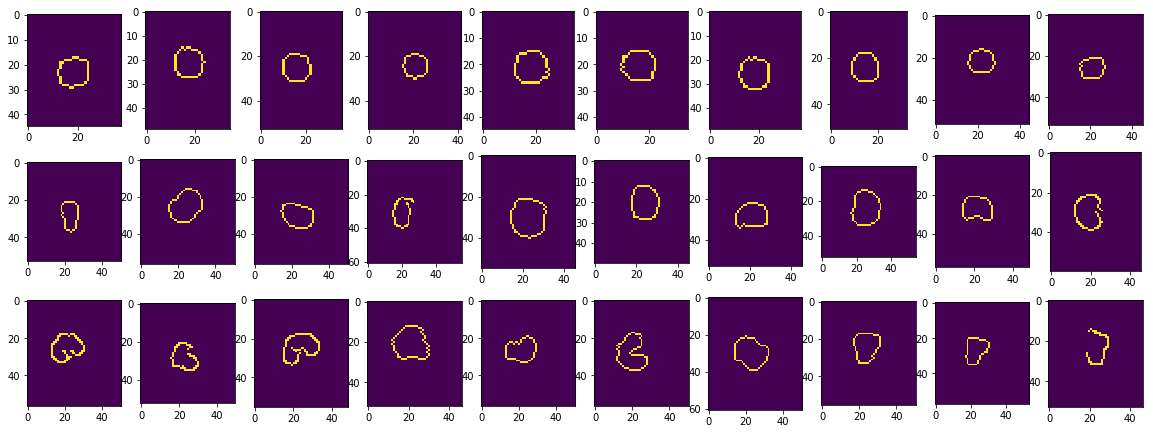

In [1280]:
contourLst = []
for i in range(30):
    contourLst.append(compute_contour_mask(clst[i].copy()))
    
plotImages(contourLst, columns=10, figsize=(20,10))

# 3. Shape Comparison:

https://www.learnopencv.com/shape-matching-using-hu-moments-c-python/


In [710]:
# Threshold image
#_,im = cv2.threshold(im, 128, 255, cv2.THRESH_BINARY)

im = contourLst[0]
# Calculate Moments
moments = cv2.moments(im)
 
# Calculate Hu Moments
huMoments = cv2.HuMoments(moments)

moments, huMoments

# Log scale hu moments
for i in range(0,7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
huMoments

array([[  2.41144635],
       [  7.06850498],
       [ 10.23106886],
       [ 11.28893704],
       [ 22.58972432],
       [-14.86162879],
       [ 22.06772607]])

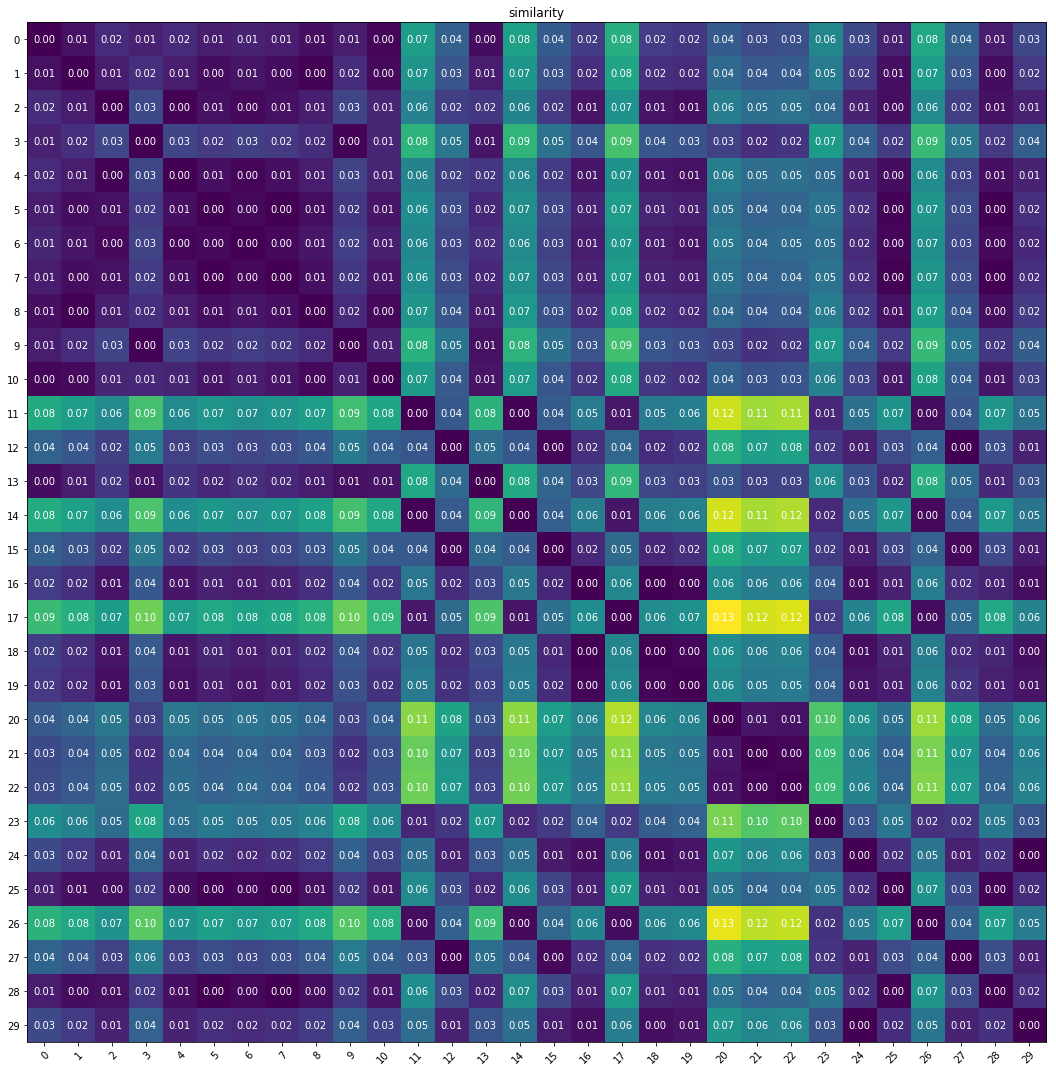

In [1281]:
n = len(contourLst)

sm = [[0.0 for g in range(n)] for f in range(n)]

for i in range(n):
    im1 = contourLst[i]
    for j in range(n):
        im2 = contourLst[j]
        sm[i][j] = cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I3,0)
PlotSimilarityMatrix(np.array(sm))

## Summary

This did not work very well. I can probably distinguish class A(rows 1-10) from the others (B: 10-20 and C: 20-30), but not the others from themselves. One way to build a classifier like this we would keep copies of the Hu Moments and do an N-nearest neighbor classifier using the contours derived from the Canny Edge Detection. 

## 4. 2-D Clustering Methods:

Can we use spatial clustering like EM to discern spatial probability landscape and then detect 1, 2 and 3 densities in classes A, B, and C, respectively? Does class C want to have more clusters than the other classes?

In [1320]:
np.argmax([x[1] for x in [[0,1],[2,9],[4,5]]], axis=0)

1

In [1641]:
def ReorderClassesBySize(img):
    h,w=img.shape
    x=img.flatten()
    num_clusters=len(np.unique(x))
    cluster_szLst = []
    for c in range(num_clusters):
        cluster_szLst.append([c, len(np.argwhere(x==c))])
    out_img = np.zeros(h*w, dtype=np.uint8)
    cluster_szLst.sort(key=lambda x:-x[1])
    for c in range(num_clusters):
        orig_c = cluster_szLst[c][0]
        out_img[np.argwhere(x==orig_c)] =c
    return out_img.reshape(img.shape)

def ReorderClassesByIntensity(img, orig_img):
    h,w=img.shape
    x=img.flatten()
    num_clusters=len(np.unique(x))
    cluster_szLst = []
    for c in range(num_clusters):
        cluster_szLst.append([c, np.mean(orig_img[np.argwhere(x==c)])])
    out_img = np.zeros(h*w, dtype=np.uint8)
    cluster_szLst.sort(key=lambda x:x[1])
    for c in range(num_clusters):
        orig_c = cluster_szLst[c][0]
        out_img[np.argwhere(x==orig_c)] =c
    return out_img.reshape(img.shape)

def ReorderBackGround(img):
    h,w=img.shape
    x=img.flatten()
    num_clusters=len(np.unique(x))
    cluster_szLst = []
    bg_class = img[2][2]
    if bg_class==0: return img
    for c in range(num_clusters):
        cluster_szLst.append([c,len(np.argwhere(x==c)), c])
    max_sz_idx = np.argmax([cc[1] for cc in cluster_szLst])
    class_to_replace = cluster_szLst[max_sz_idx][2]
    cluster_szLst[max_sz_idx][2]=0
    cluster_szLst[0][2]=class_to_replace
    out_img = np.zeros(h*w, dtype=np.uint8)
    for c in range(num_clusters):
        orig_class = cluster_szLst[c][0]
        new_class = cluster_szLst[c][2]
        out_img[np.argwhere(x==orig_class)]=new_class
    return out_img.reshape(img.shape)

def getsamples_img(img, data_weight=1.0):
    r, c = img.shape
    out_arr = np.zeros((r*c,3), dtype=np.float)
    idx = 0
    for i in range(r):
        for j in range(c):
            v = img[i][j]*data_weight
            out_arr[idx] = np.array([float(i),float(j),v])
            idx+=1
    out_arr = out_arr / out_arr.sum(axis=0)*np.array([1.0,1.0,data_weight])
    return out_arr

def RunEMSegmentation(img, init_clusters=4, data_weight=1.0):
    X_train = getsamples_img(img, data_weight=data_weight)    
    em = cv2.ml.EM_create()
    em.setClustersNumber(init_clusters)
    _, v, classLst, probs = em.trainEM(X_train)
    classLst = classLst.flatten()
    means = em.getMeans()
    num_clusters = len(means)
    #print(num_clusters, means)
    x, y = img.shape
    output_img = np.zeros((x,y), dtype=np.uint8)
    idx=0
    for i in range(x):
        for j in range(y):
            output_img[i,j] = classLst[idx]
            idx+=1
    unique, counts = np.unique(classLst, return_counts=True)
    #print ("EM: ", unique, counts)
    num_classes = len(np.unique(num_clusters))
    cm = []
    for c in range(num_clusters):
        class_idxLst = np.argwhere(classLst==c).flatten()
        cm.append(np.mean(probs[class_idxLst], axis=0))
    cm = np.array(cm)
    return ReorderClassesByIntensity(output_img, img.flatten()), classLst, cm, probs, num_clusters

def floodFillShape(mask):
    x,y = mask.shape
    mask1 = np.zeros([x+2,y+2], np.uint8)
    cv2.floodFill(mask.copy(),mask1,(0,0),True)
    mask_inv=cv2.bitwise_not(mask1)
    return mask_inv[:-2,:-2]-254

def AndOrShape(m1, m2, Verbose=False):
    ff = floodFillShape(m1).astype(np.bool)
    a = ff&m2
    o = ff|m2
    ret = [imidx, m1.sum(), m2.sum(), a.sum(), o.sum(), a.sum()/o.sum()]
    if Verbose:
        print(ret)
        plotImages([m1, m2, ff, a, o])
    return ret

def draw_contours(im, contours, hierarchy):
    #im, contours, hierarchy = cv2.findContours(em_imgLst[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print("len(contours)", len(contours))
    mask = np.zeros(img_shape, dtype=np.uint8)
    c_idx = int(np.argmax([len(cont) for cont in contours]))
    print ("c_idx", c_idx, len(contours[c_idx]))
    im = cv2.drawContours(im, contours, c_idx, 100, 1)
    x = im.flatten()
    print(x[x>0])
    imshow(im)  

### Run One EM clustering run

type: <class 'numpy.ndarray'> dtype: uint8 sz: (49, 35), max_val: 7 pixels>0: 378 of 1715
type: <class 'numpy.ndarray'> dtype: uint8 sz: (49, 35), max_val: 7 pixels>0: 378 of 1715
type: <class 'numpy.ndarray'> dtype: uint8 sz: (57, 51), max_val: 7 pixels>0: 518 of 2907
type: <class 'numpy.ndarray'> dtype: uint8 sz: (57, 51), max_val: 7 pixels>0: 518 of 2907
type: <class 'numpy.ndarray'> dtype: uint8 sz: (53, 50), max_val: 7 pixels>0: 420 of 2650
type: <class 'numpy.ndarray'> dtype: uint8 sz: (53, 50), max_val: 7 pixels>0: 420 of 2650


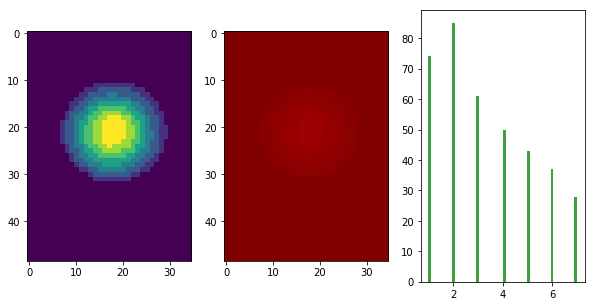

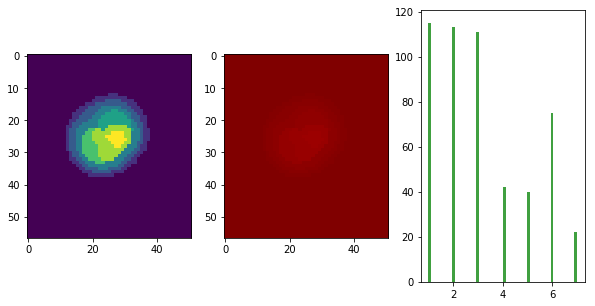

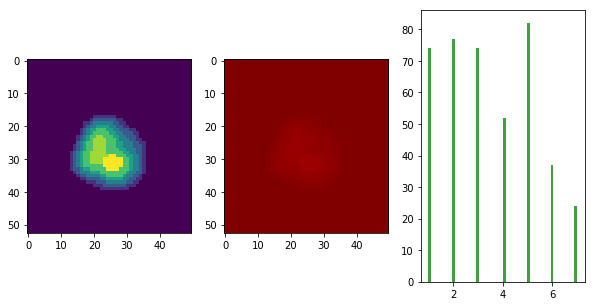

In [1380]:
cl=8;w=5
idx = 1
tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
ret1,thrtif_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
oimg, classLst, cm1, probs1, num_classes = RunEMSegmentation(thrtif_img, init_clusters=cl, data_weight=w)
x = oimg.flatten()
#print ("\n\nx[x>0]", x[x>0])
image_show_histo(oimg, figsize=(10,5))

idx = 11
tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
ret1,thrtif_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
oimg2, classLst, cm2, probs2, num_classes = RunEMSegmentation(thrtif_img, init_clusters=cl, data_weight=w)
x = oimg2.flatten()
image_show_histo(oimg2, figsize=(10,5))

idx = 21
tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
ret1,thrtif_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
oimg3, classLst, cm3, probs3, num_classes = RunEMSegmentation(thrtif_img, init_clusters=cl, data_weight=w)
x = oimg3.flatten()
image_show_histo(oimg3, figsize=(10,5))

In [ ]:
f, axs = plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,3,1)
sns.heatmap(pd.DataFrame(probs1, columns=[str(c) for c in range(num_classes)]), vmin=0, vmax=1.0)
plt.subplot(1,3,2)
sns.heatmap(pd.DataFrame(probs2, columns=[str(c) for c in range(num_classes)]), vmin=0, vmax=1.0)
plt.subplot(1,3,3)
sns.heatmap(pd.DataFrame(probs3, columns=[str(c) for c in range(num_classes)]), vmin=0, vmax=1.0)
print(np.diagonal(cm1).sum()/cm1.sum(), np.diagonal(cm2).sum()/cm2.sum(), np.diagonal(cm3).sum()/cm2.sum())

### EM for all 30 images:  
Ordering the colors by intensity, and choosing a cluster_size of 7 gets more consistent coloring.

In [1649]:
num_clusters=7
em_imgLst = [];cmLst = [];probLst=[]
for idx in range(30):
    tif_img=imgLst_u16[idx];img=imgLst_u8[idx]
    ret1,thresh_img = cv2.threshold(tif_img,100,2500,cv2.THRESH_TOZERO)
    oimg, classLst, cm, prob, num_classes = RunEMSegmentation(thresh_img, init_clusters=num_clusters, data_weight=5.0)
    em_imgLst.append(oimg)
    cmLst.append(cm)
    probLst.append(prob)

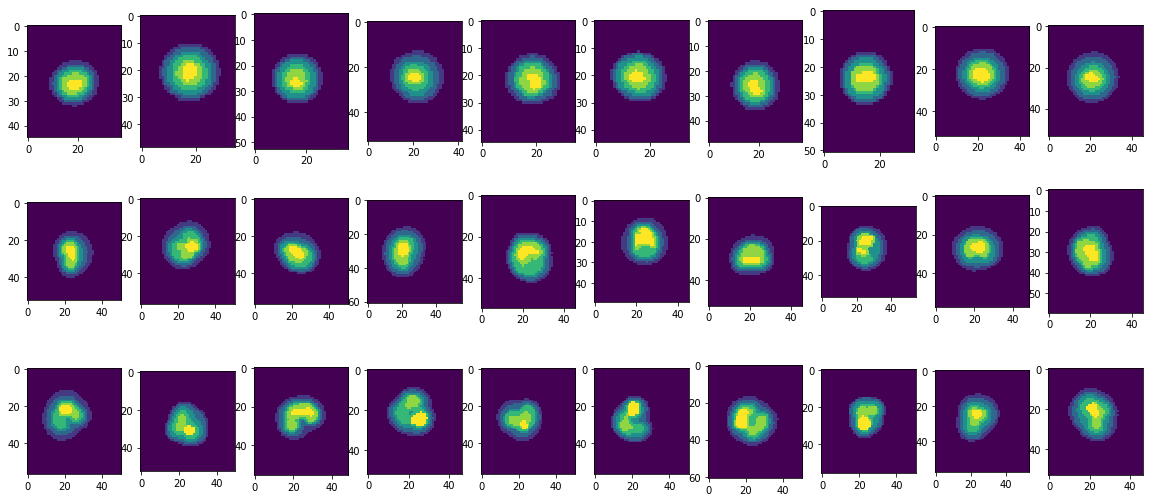

In [1650]:
plotImages(em_imgLst, figsize=(20,12))

### This also does not work there's no way to see patterns splitting the intensity populations

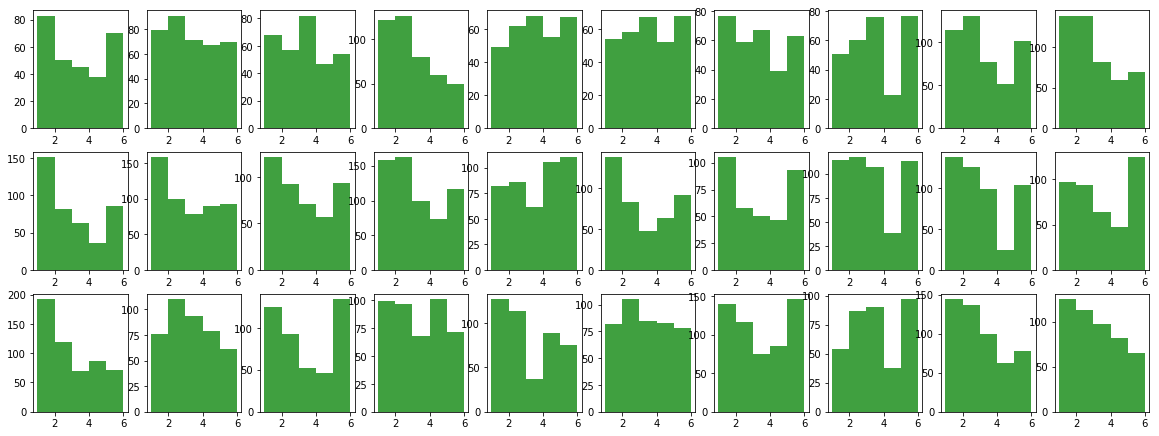

In [1392]:
plotImages(em_imgLst, PlotHisto=num_clusters)

In [1651]:
em_contourLst = []
mLst = [];cntLst=[];andor=[]
for imidx in range(30):
    print(imidx, end='\r')
    img = em_imgLst[imidx]
    img_shape = img.shape
    x = img.flatten()
    img_sz = np.prod(img_shape)
    num_clusters = len(np.unique(x))
    for c in range(5,7,1):
        mask_img = np.zeros(img_sz, dtype=np.uint8)
        mask_img[np.argwhere(x==c)]=1
        mask_img = mask_img.reshape(img_shape)
        mLst.append(mask_img)
        #Contours
#         mask_img = cv2.normalize(src=mask_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32SC1)
#         im, contours, hierarchy = cv2.findContours(mask_img, cv2.RETR_FLOODFILL , cv2.CHAIN_APPROX_NONE)
#         max_c_idx = np.argmax([len(cont) for cont in contours])
#         em_contourLst.append(contours[max_c_idx])
        #mLst.append(cv2.drawContours(np.zeros(img_shape, dtype=np.uint8), contours, max_c_idx, 100, 1))
    m1 = mLst[-2]
    m2 = mLst[-1]
    andor.append(AndOrShape(m1, m2, Verbose=False))

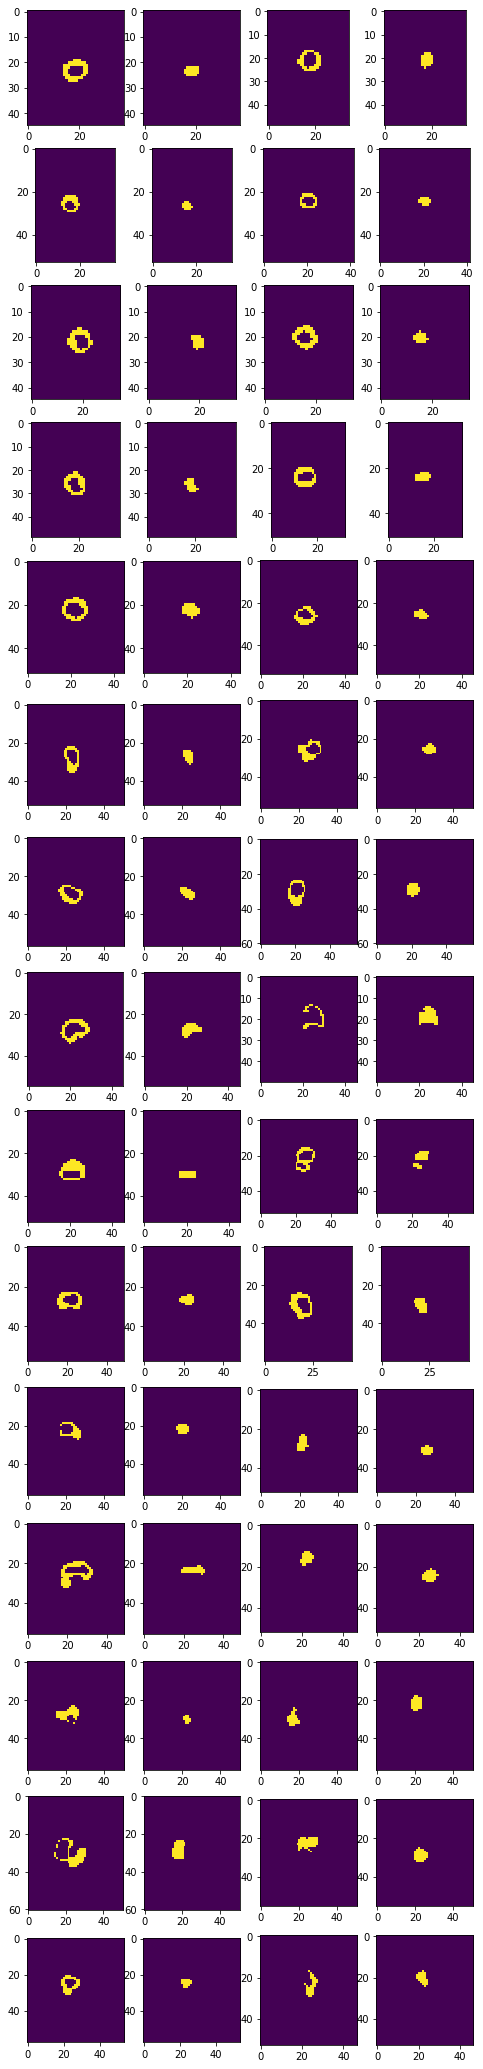

In [1652]:
plotImages(mLst, columns = 4,figsize=(8,40))

In [ ]:
clst = []
step=10
for i in range(0,30,1):
    clst.append(cv2.Canny(em_imgLst[i], 1,255,apertureSize = 3))
plotImages(clst, columns = 10)

In [1653]:
andor

[[0, 49, 21, 21, 70, 0.29999999999999999],
 [1, 42, 28, 28, 70, 0.40000000000000002],
 [2, 40, 14, 14, 54, 0.25925925925925924],
 [3, 30, 19, 19, 49, 0.38775510204081631],
 [4, 49, 22, 22, 71, 0.30985915492957744],
 [5, 48, 20, 20, 68, 0.29411764705882354],
 [6, 47, 23, 23, 70, 0.32857142857142857],
 [7, 53, 24, 24, 77, 0.31168831168831168],
 [8, 60, 42, 42, 102, 0.41176470588235292],
 [9, 46, 24, 22, 72, 0.30555555555555558],
 [10, 55, 31, 31, 86, 0.36046511627906974],
 [11, 63, 29, 29, 92, 0.31521739130434784],
 [12, 57, 37, 37, 94, 0.39361702127659576],
 [13, 71, 46, 46, 117, 0.39316239316239315],
 [14, 67, 43, 43, 110, 0.39090909090909093],
 [15, 32, 59, 7, 84, 0.083333333333333329],
 [16, 69, 24, 24, 93, 0.25806451612903225],
 [17, 69, 45, 45, 114, 0.39473684210526316],
 [18, 66, 37, 37, 103, 0.35922330097087379],
 [19, 83, 42, 42, 125, 0.33600000000000002],
 [20, 41, 30, 6, 65, 0.092307692307692313],
 [21, 37, 24, 5, 56, 0.089285714285714288],
 [22, 97, 37, 37, 134, 0.27611940298

In [1348]:
#cv2.RETR_EXTERNAL
#Hierarchy: [Next, Previous, First_Child, Parent] 
def compute_contour_mask(in_img):
    im2, contours, hierarchy = cv2.findContours(in_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    o_img = np.zeros(in_img.shape, dtype=np.uint8)
    if len(contours[0])>150:
        c_idx = 1
    else:
        c_idx = 0
    c_idx = min(len(contours)-1, c_idx)
    ximg = cv2.drawContours(o_img, contours, c_idx, (255,255,255), 1)
    return ximg
def compute_contour_mask_all(in_img):
    im2, contours, hierarchy = cv2.findContours(in_img*10, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    o_img = np.zeros(in_img.shape, dtype=np.uint8)
    for c_idx in range(len(contours)):
        o_img = cv2.drawContours(o_img, contours, c_idx, (255,255,255), 1)
    return o_img

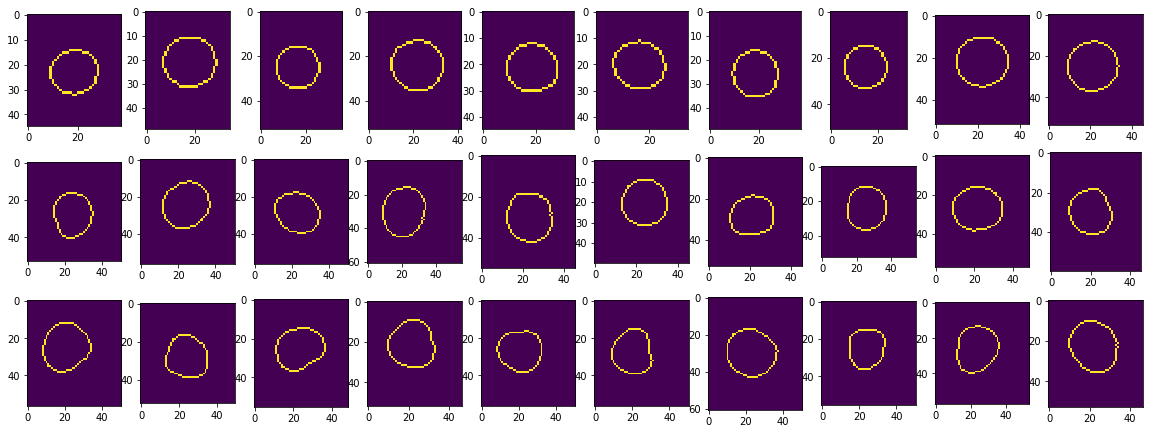

In [1393]:
contourLst = []
for i in range(30):
    #contour, contour_img = 
    contourLst.append(compute_contour_mask_all(em_imgLst[i].copy()))
    
plotImages(contourLst, columns=10, figsize=(20,10))

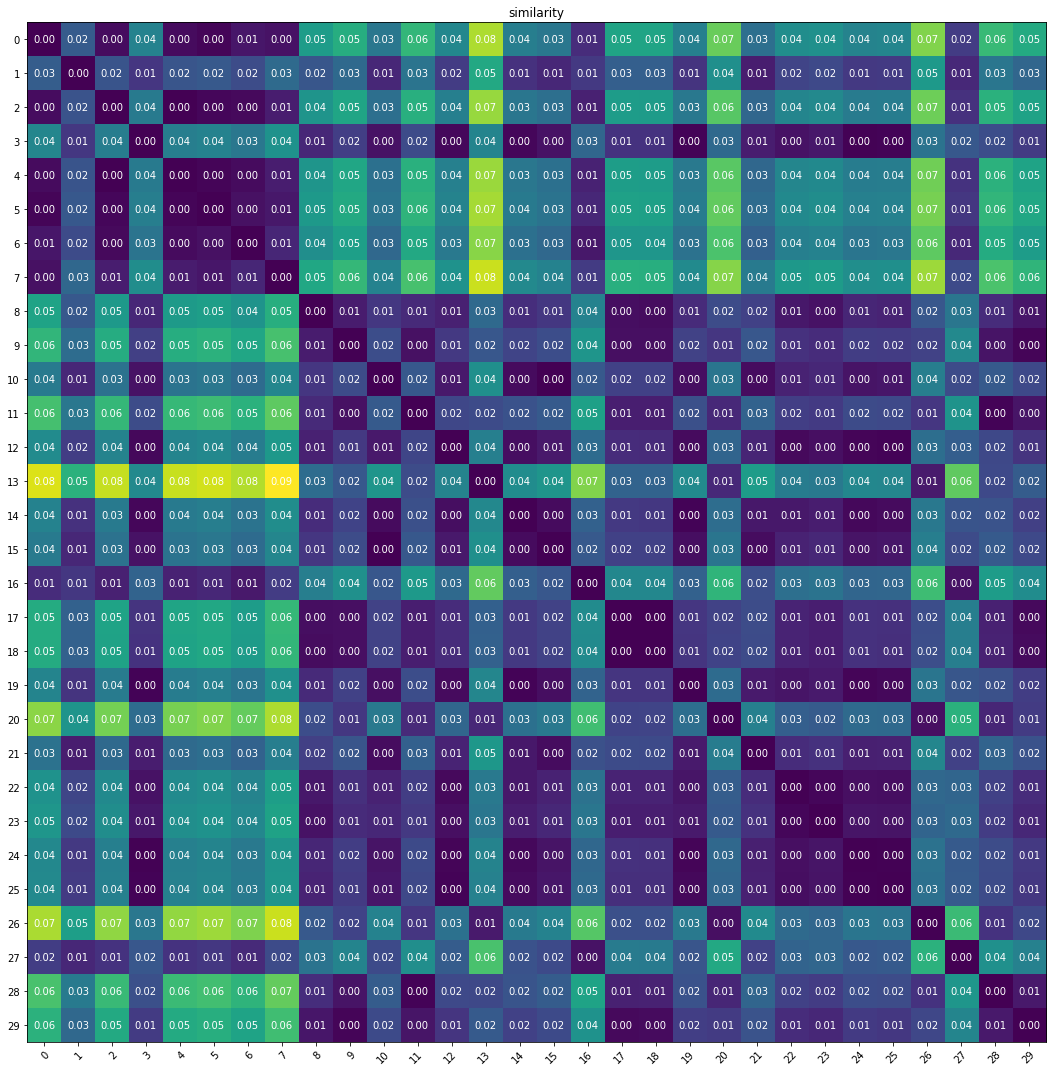

In [1367]:
n = len(contourLst)

sm = [[0.0 for g in range(n)] for f in range(n)]

for i in range(n):
    im1 = contourLst[i]
    for j in range(n):
        im2 = contourLst[j]
        sm[i][j] = cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I3,0)
PlotSimilarityMatrix(np.array(sm))

### Class to Class Confusion Matrix:  
In this case we wanted tos ee if images that naturally had more classes would be detectable. 

#### We set the cluster number arbitrarily to 6. This implementation of EM does not adjust the clusters during the run, so I was hoping that maybe by looking at quality of clusters as seen by the Confusion Matrix, we might see that those groups would prefer a different number of clusters. We can also pull a mask around the cell and look for clustering quality there. 

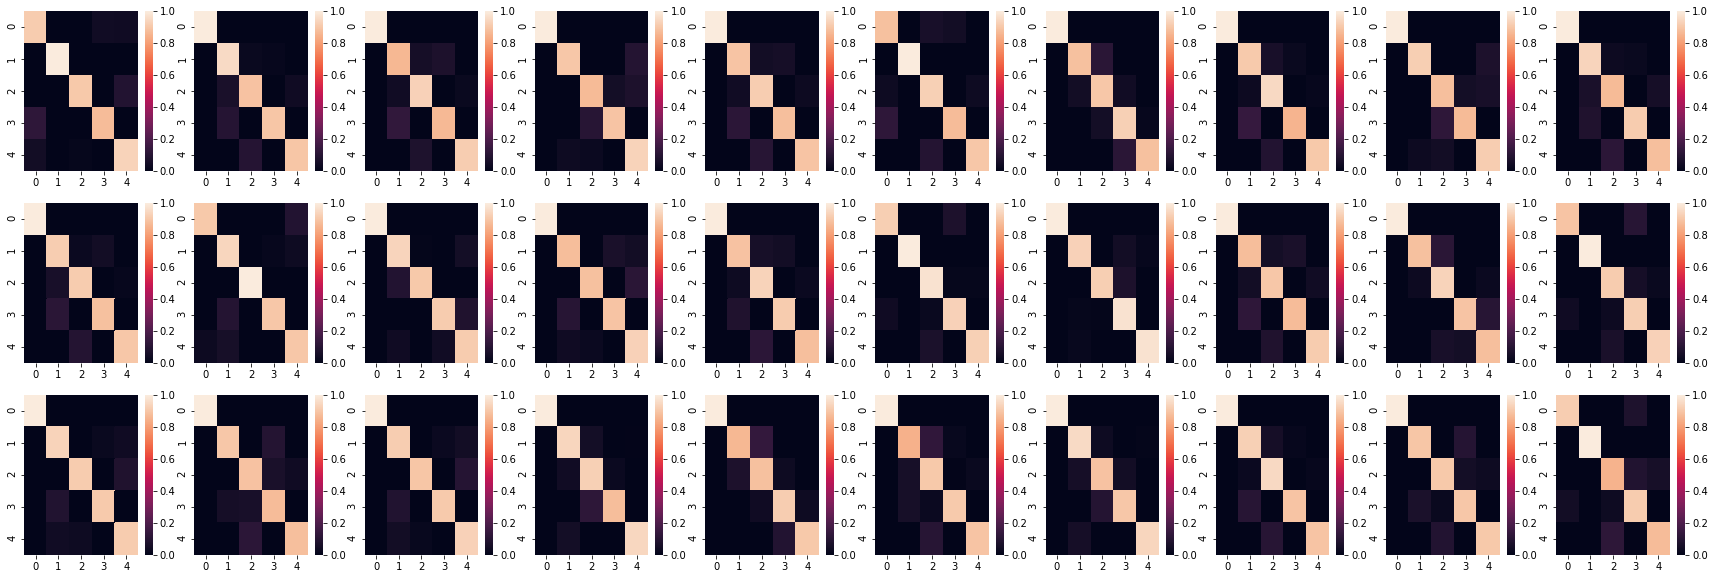

In [1305]:
import seaborn as sns

f, axs = plt.subplots(3,10,figsize=(30,10))
for i in range(30):
    plt.subplot(3,10,i+1)
    sns.heatmap(pd.DataFrame(cmLst[i], columns=[str(c) for c in range(num_classes)]), vmin=0, vmax=1.0)


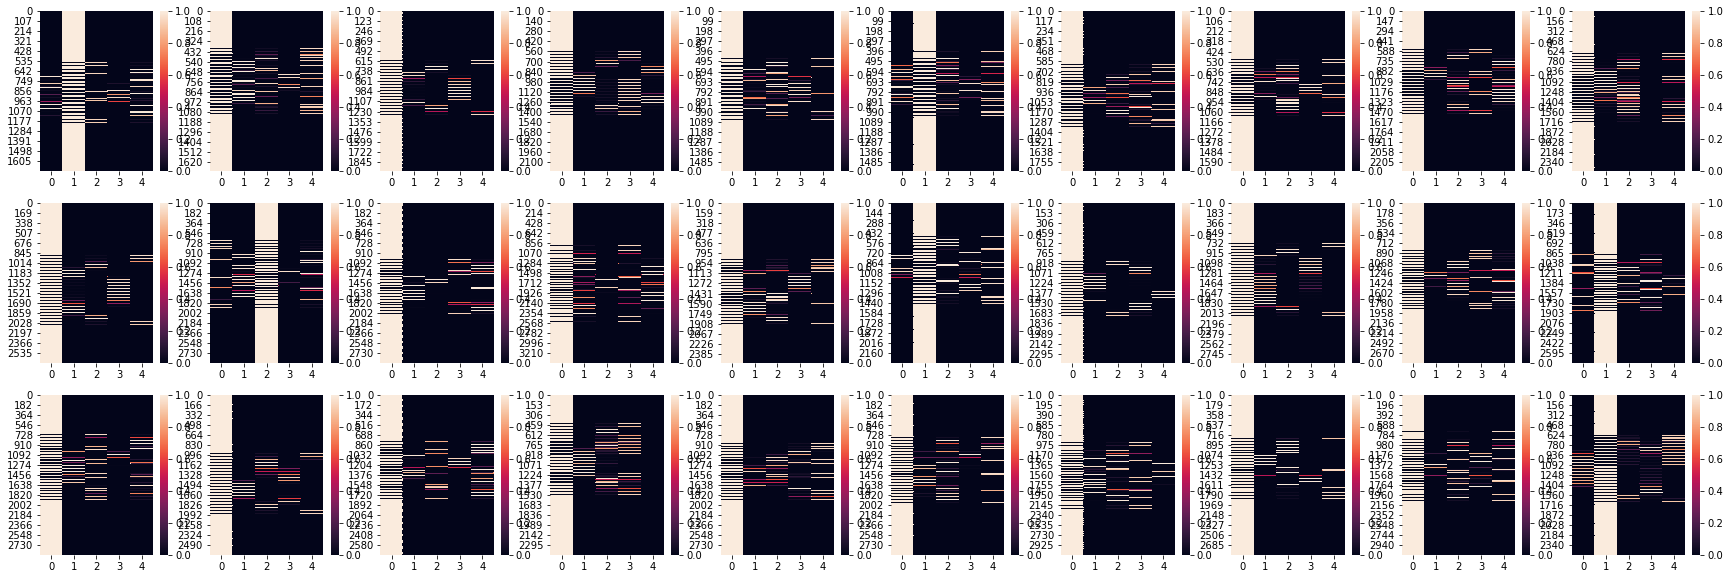

In [1306]:
#This was a mistake, but it is very cool Its a class histogram plotted on linearized xy space
import seaborn as sns

f, axs = plt.subplots(3,10,figsize=(30,10))
for i in range(30):
    plt.subplot(3,10,i+1)
    sns.heatmap(pd.DataFrame(probLst[i], columns=[str(c) for c in range(num_classes)]), vmin=0, vmax=1.0)


### Pixel Off Diagonal score for all confusion matrices: 
This is a way of determining how good the clustering is. 

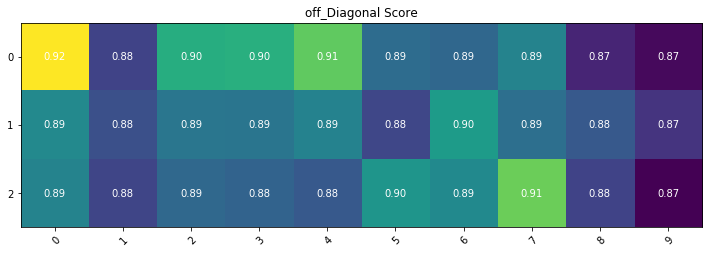

In [1122]:
#Score the off diagonals for all 30 images
off_diagonal= np.zeros((3,10))
idx = 0
for i in range(3):
    for j in range(10):
        cm = cmLst[idx]
        off_diagonal[i][j]= np.diagonal(cm).sum()/cm.sum()
        idx+=1
    
PlotSimilarityMatrix(off_diagonal, figsize=(10,10), no_plot=False, title='off_Diagonal Score')

In [1123]:
off_diagonal.shape, off_diagonal, off_diagonal.sum(axis=1)

((3, 10),
 array([[ 0.92376366,  0.87742142,  0.90180338,  0.90229009,  0.90955721,
          0.88622849,  0.88500798,  0.89169927,  0.87171102,  0.86723651],
        [ 0.89294571,  0.87993753,  0.8884593 ,  0.88818056,  0.89135906,
          0.87812623,  0.89756647,  0.8868725 ,  0.88189437,  0.8745189 ],
        [ 0.89156509,  0.87789613,  0.88538433,  0.88428019,  0.88180329,
          0.89591339,  0.89324595,  0.91063438,  0.87748845,  0.86569898]]),
 array([ 8.91671902,  8.85986061,  8.86391019]))

### Summary: 

This is probably not super effective. I would have liked to see pixel misclustering on the bottom row, and indeed the lower row is marginally lower, but its not really conclusive at this time. The safest route is to use the shapes we derived above and build a kind of nearest neighbor approach to initial classification. As more data comes in, we can use this approach to agglomerate more images into these groups and then apply machine learning techniques to build a far better classifier than mere heuristics.








# Deprecation Line: 


#### A very bad way of importing images uses the 8uc1 mode. It severley compresses the data, but the resultant sparse yellow images are very pretty and they have slightly better inter/intra-group similarity metrics.

type: <class 'numpy.ndarray'> dtype: uint8 sz: (45, 38), max_val: 220 pixels>0: 206 of 1710
type: <class 'numpy.ndarray'> dtype: uint8 sz: (45, 38), max_val: 220 pixels>0: 206 of 1710


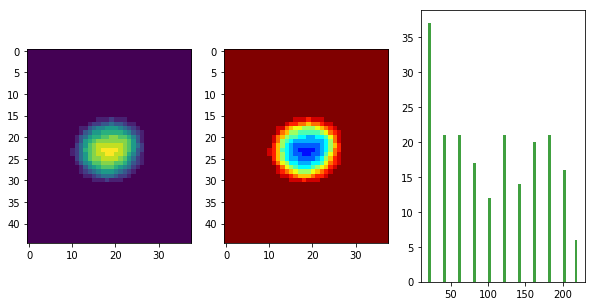

In [584]:
image_show_histo(imgLst_8uc1[0]*20)

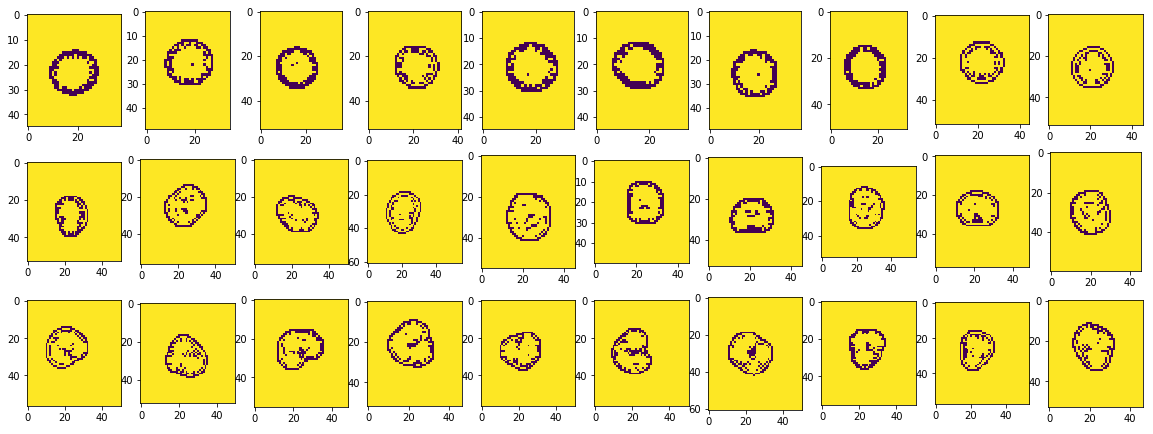

In [568]:
#Adaptive Thresholding

def threshImages(imgLst):
    thrsLst = []
    for img in imgLst:
        #threshed_im = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, -1)
        threshed_im = cv2.adaptiveThreshold(img*20, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 5)
        thrsLst.append(threshed_im)
    return thrsLst
    
thrsLst = threshImages(imgLst_8uc1)#(imgLst_u8)
plotImages(thrsLst)

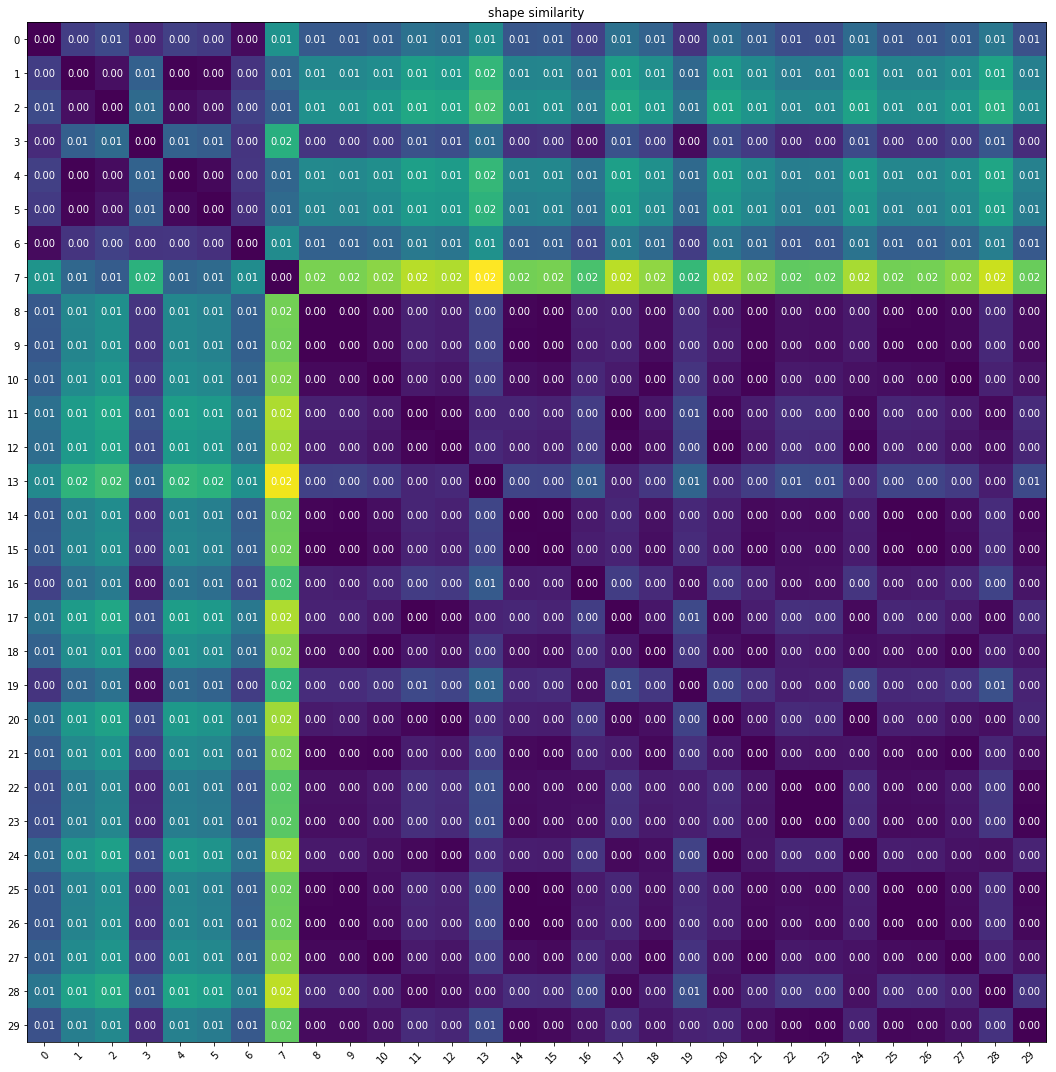

In [714]:
n = len(contourLst)

sm = [[0.0 for g in range(n)] for f in range(n)]

for i in range(n):
    im1 = thrsLst[i]
    for j in range(n):
        im2 = thrsLst[j]
        sm[i][j] = cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I3,0)
PlotSimilarityMatrix(sm)

## Can we detect simple shapes in the profiles? NO

10 n=1 Circle
type: <class 'numpy.ndarray'> dtype: uint8 sz: (45, 38), max_val: 11 pixels>0: 206
type: <class 'numpy.ndarray'> dtype: int32 sz: (1, 3, 4), max_val: 2 pixels>0: 3


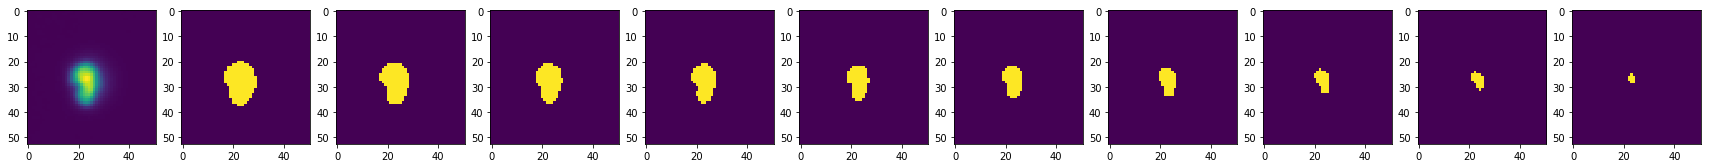

In [268]:
#https://pysource.com/2018/09/25/simple-shape-detection-opencv-with-python-3/
def detect_shapes(cnt):
    oLst = []
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    if len(approx) == 3:
        oLst.append("Triangle")
    elif len(approx) == 4:
        oLst.append("Rectangle")
    elif len(approx) == 5:
        oLst.append("Pentagon")
    elif 6 < len(approx) < 15:
        oLst.append("Ellipse")
    else:
        oLst.append("Circle")
    return oLst[0], approx
dlst=[]
C=4
cols = 11#2+C
for i in range(10,11,1):
    img = imgLst_u8[i].copy()
    dlst.append(img)
    #_, contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for start in range(55,250,20):
        ret, timg = cv2.threshold(img, start, start+50, cv2.THRESH_BINARY)
        dlst.append(timg)
    if None:
        _,contours,hierarchy = cv2.findContours(timg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        num_contours = len(contours)
        for i in range(min(C, len(contours))):
            cnt = contours[i]
            shape, approx = detect_shapes(cnt)
            drawimg = np.zeros(img.shape, img.dtype)
            cv2.drawContours(drawimg, contours, i, (255,255,100), 1)
            dlst.append(drawimg)
        for c in range(max(0,C-num_contours)):
            dlst.append(np.zeros(img.shape, img.dtype))
    print(i, "n=%i %s"%(len(contours), shape))
image_stats(x)
image_stats(y)
plotImages(dlst, columns = cols,figsize=(30,80))

## Watershed method 

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html


type: <class 'numpy.ndarray'> dtype: uint8 sz: (53, 51), max_val: 255 pixels>0: 2352 of 2703


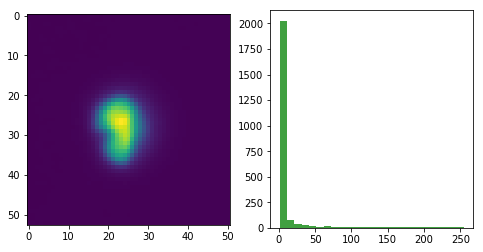

In [348]:
img_path = fileLst[25]
gray= imgLst_u8[10]#cv2.imread(img_path, cv2.CV_8UC1)*20;
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#First approximate edges:
#ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, thresh = cv2.threshold(gray,100,255,cv2.THRESH_BINARY)#_INV+cv2.THRESH_OTSU)
image_show_histo(gray, figsize=(8,4))

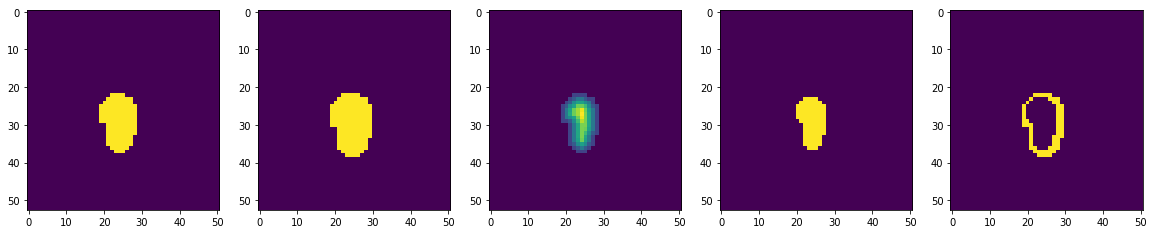

In [349]:
# noise removal
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=1)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
#imshow(dist_transform)
plotImages([opening, sure_bg, dist_transform, sure_fg, unknown],columns=5, figsize=(20,10))

In [ ]:
# Watershed: Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

ggray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB).astype(np.int8)
markers = cv2.watershed(ggray,markers)
img[markers == -1] = [255,0,0]

imshow(markers)

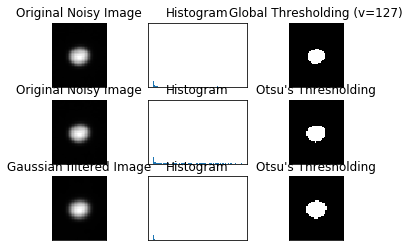

In [588]:
#More Thresholding

img = imgLst_u8[0]

# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

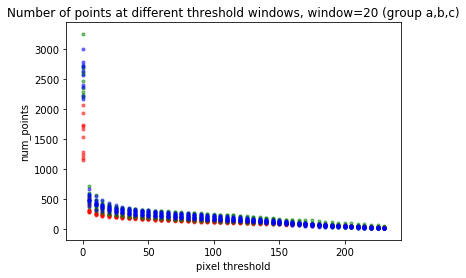

In [579]:
#Even More thresholding
#https://docs.opencv.org/3.2.0/d7/d4d/tutorial_py_thresholding.html
def threshold_test(img):
    vlst = [];thrlst=[]
    for i in range(0,235,5):
        ret, thresh_img = cv2.threshold(img, i, i+20, cv2.THRESH_BINARY)
        x = thresh_img.flatten()
        vlst.append([i, len(x[x>0])])
        thrlst.append(thresh_img)
    return vlst, thrlst
colors = ("red", "green", "blue")
plotLst = []
idx = 0
for img in imgLst_u8[:]:
    l, thrlst = threshold_test(img)
    area = np.pi*3
    x = [v[0] for v in l]
    y = [v[1] for v in l]
    plt.scatter(x, y, s=area, c=colors[int(idx/10)], alpha=0.5)
    plt.title('Number of points at different threshold windows, window=20 (group a,b,c)')
    plt.xlabel('pixel threshold')
    plt.ylabel('num_points')
    plotLst.append(plt)
    idx+=1
    
plt.show()
plotImages(thrlst, columns = 10)

#### scipy GaussianMixture: I would have done this or even DBScan, but they don't have openCV Cpp libraries EM does. It will be a cinch to implement it.

2452

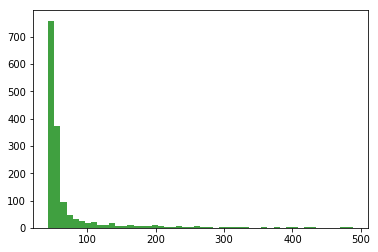

In [1167]:
x = imgLst_u16[1].flatten()
c,vv,pp = plt.hist(x[x<500], 50, density=False, facecolor='g', alpha=0.75)
x.max()

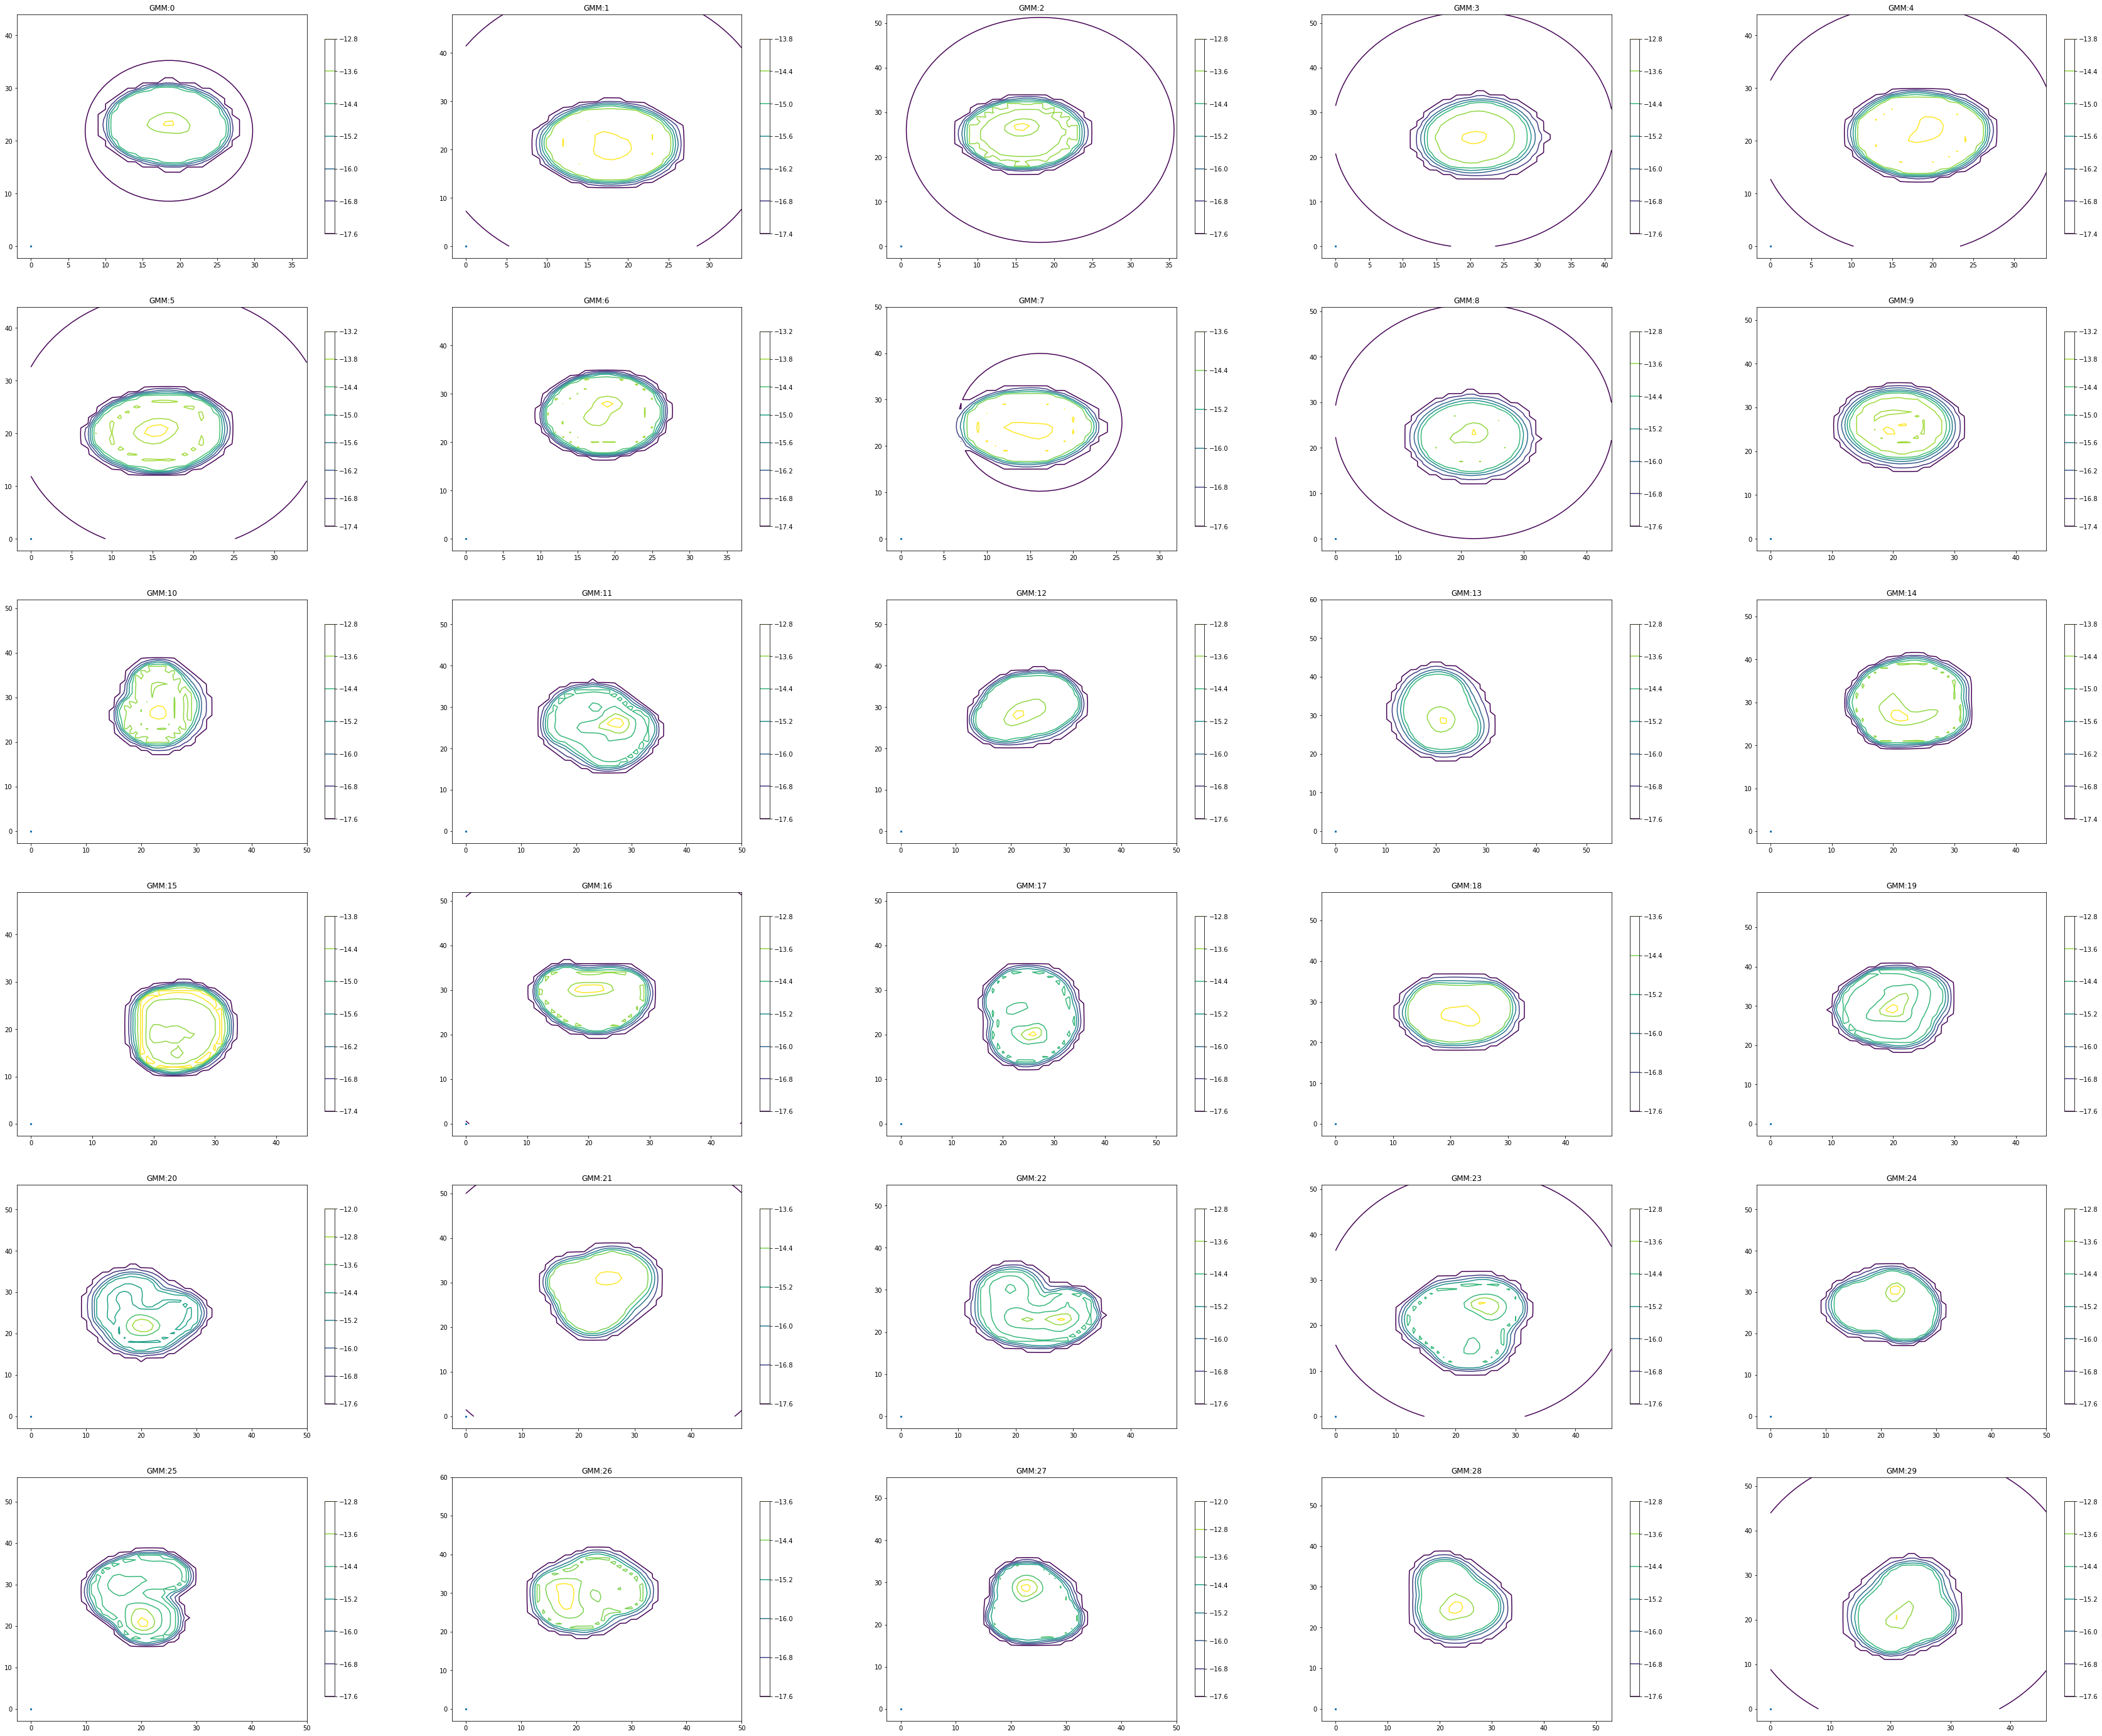

[[  4.06964369e-04   4.02522762e-04   1.05821392e-04]
 [  3.39775643e-04   3.94683851e-04   1.01273959e-02]
 [  3.50684247e-04   3.85512524e-04   5.45668701e-03]
 [  4.07183487e-04   4.02625522e-04   9.60443529e-05]]


In [1396]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

f, axs = plt.subplots(6,5,figsize=(60,50))
for i in range(30):
    tif_img = imgLst_u16[i]
    r,c = tif_img.shape
    ret1,thresh_img = cv2.threshold(tif_img,200,2500,cv2.THRESH_TOZERO)
    #thresh_img=em_imgLst[i]#
    X_train = getsamples_img(thresh_img, data_weight=2.0)
    clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
    clf.fit(X_train)

    # display predicted scores by the model as a contour plot
    x = np.arange(0, c)
    y = np.arange(0, r)
    X, Y = np.meshgrid(x,y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(X_train)
    Z = Z.reshape((r,c))
    plt.subplot(6,5,i+1)
    CS = plt.contour(X, Y, Z)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    
    plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    plt.title('GMM:%i'%i)
    plt.axis('tight')
plt.show()
print(clf.means_)

(391524, (45, 38))

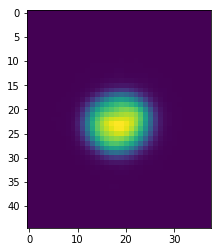

In [1670]:
p = ud+"sps_Image.jpg"
p=ud+"classA/ClassA_4_Ch7.ome.tif"
#img = plt.imread(p)
img=np.int16(cv2.imread(img_p, -1))
plt.imshow(img)
img.sum(), img.shape

type: <class 'numpy.ndarray'> dtype: uint8 sz: (900, 700, 3), max_val: 0 pixels>0: 0 of 630000


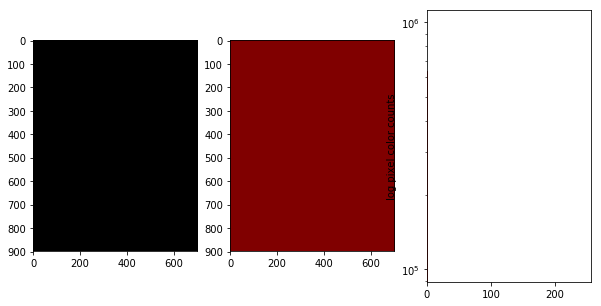

In [1665]:
image_show_histo(img, figsize=(10,5))

In [1666]:
img.max()

0